# Question 2

In [49]:
import numpy as np 
import matplotlib.pyplot as plt 
from numpy.linalg import inv 

# Set seed for reproducibility
np.random.seed(42)

# Function to generate datasets with different fanning patterns
def generate_fanning_data(pattern, n=100):
    X = np.linspace(1, 10, n)[:, np.newaxis]
    true_beta = 3 

    if pattern == "diagonal":
        y = true_beta * X.squeeze() + np.random.normal(0, X.squeeze() * 2, size=n)
    elif pattern == "backward":
        y = true_beta * X.squeeze() + np.random.normal(0, (11 - X.squeeze()) * 2, size=n)
    elif pattern == "central":
        y = true_beta * X.squeeze() + np.random.normal(0, X.squeeze()**4, size=n)

    return X, y

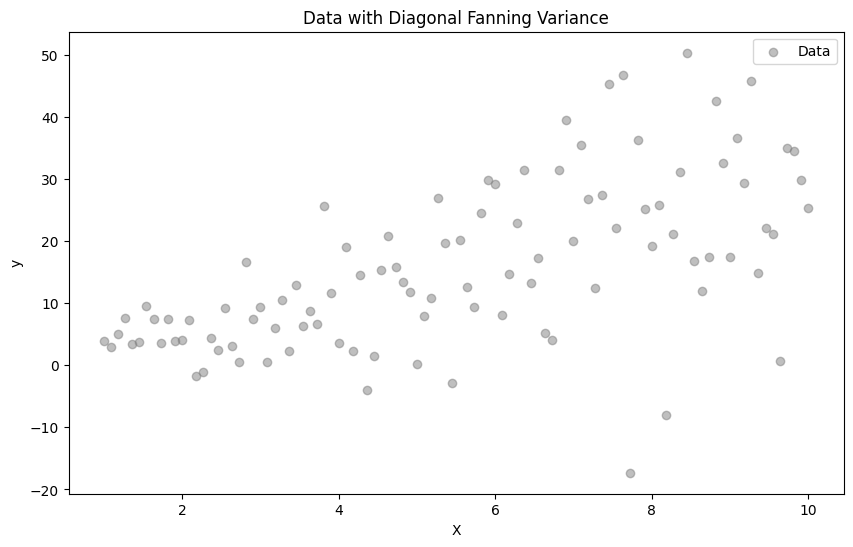

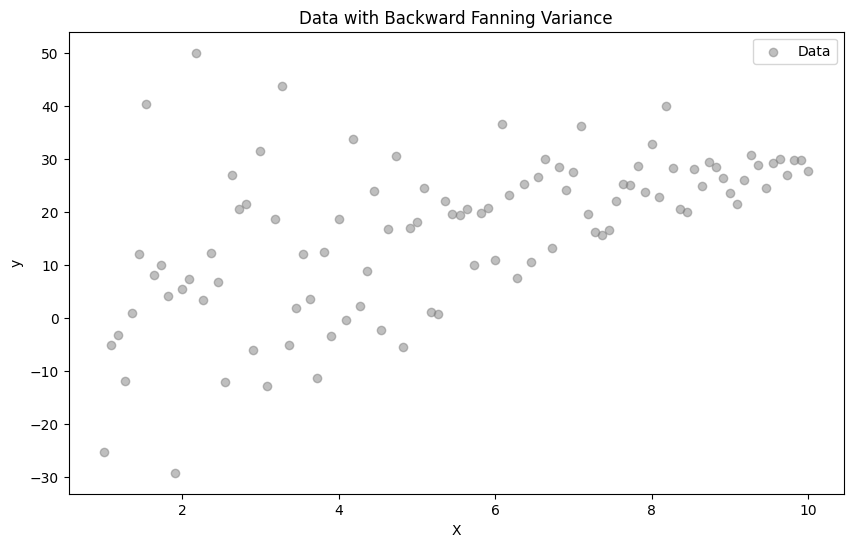

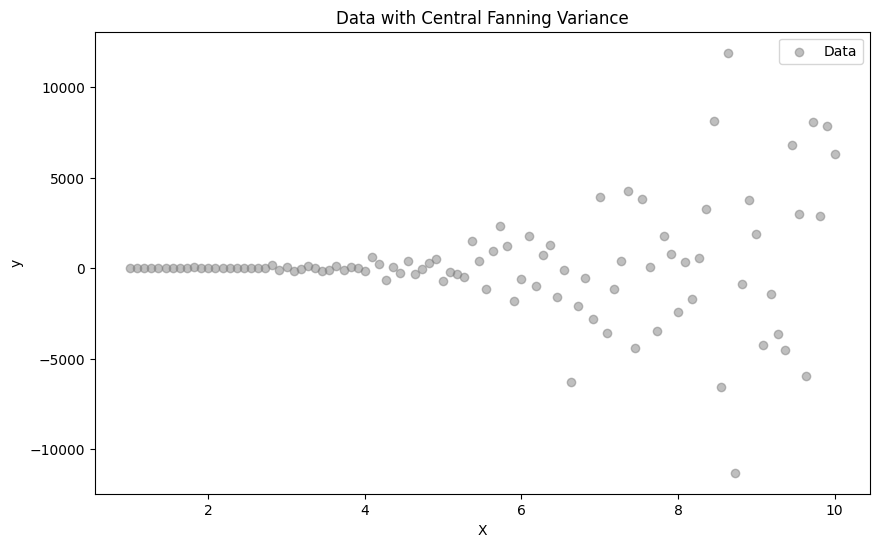

In [50]:
for pattern in ["diagonal", "backward", "central"]:
    X, y = generate_fanning_data(pattern)
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="gray", alpha=0.5, label="Data")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"Data with {pattern.capitalize()} Fanning Variance")
    plt.legend()
    plt.show()

In [51]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Function to calculate WLS predictions
def calculate_wls_predictions(X_b, y, weights):
    W = np.diag(weights)
    beta = inv(X_b.T @ W @ X_b) @ (X_b.T @ W @ y)
    return X_b @ beta, beta

# Function to fit each regression model and store coefficients
def fit_models(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]  # Adding intercept term
    results = {}
    
    # 1. Closed-form WLS with weight ~ 1/X^4
    weights_x4 = 1 / (X.squeeze() ** 2)
    y_pred_x4, beta_x4 = calculate_wls_predictions(X_b, y, weights_x4)
    results["Closed-form WLS (1/X^2)"] = (y_pred_x4, beta_x4)

    # 2. Closed-form WLS with weight ~ 1/e^(-X)
    weights_exp = np.exp(-X.squeeze())
    y_pred_exp, beta_exp = calculate_wls_predictions(X_b, y, weights_exp)
    results["Closed-form WLS (e^-X)"] = (y_pred_exp, beta_exp)

    # 3. Closed-form WLS with weight ~ 1/σ^2 (estimated variance from residuals)
    initial_model = LinearRegression().fit(X, y)
    residuals = y - initial_model.predict(X)
    variance_estimates = residuals ** 2
    weights_sigma = 1 / variance_estimates
    y_pred_sigma, beta_sigma = calculate_wls_predictions(X_b, y, weights_sigma)
    results["Closed-form WLS (1/σ^2)"] = (y_pred_sigma, beta_sigma)

    # 4. sklearn's OLS
    ols_model = LinearRegression().fit(X, y)
    y_pred_ols = ols_model.predict(X)
    beta_ols = np.array([ols_model.intercept_, ols_model.coef_[0]])
    results["sklearn OLS"] = (y_pred_ols, beta_ols)

    # 5. sklearn's WLS using statsmodels
    wls_model = LinearRegression().fit(X, y, sample_weight=weights_sigma)
    y_pred_wls = wls_model.predict(X)
    beta_wls = np.array([wls_model.intercept_, wls_model.coef_[0]])
    results["sklearn WLS (1/σ^2)"] = (y_pred_wls, beta_wls)

    return results

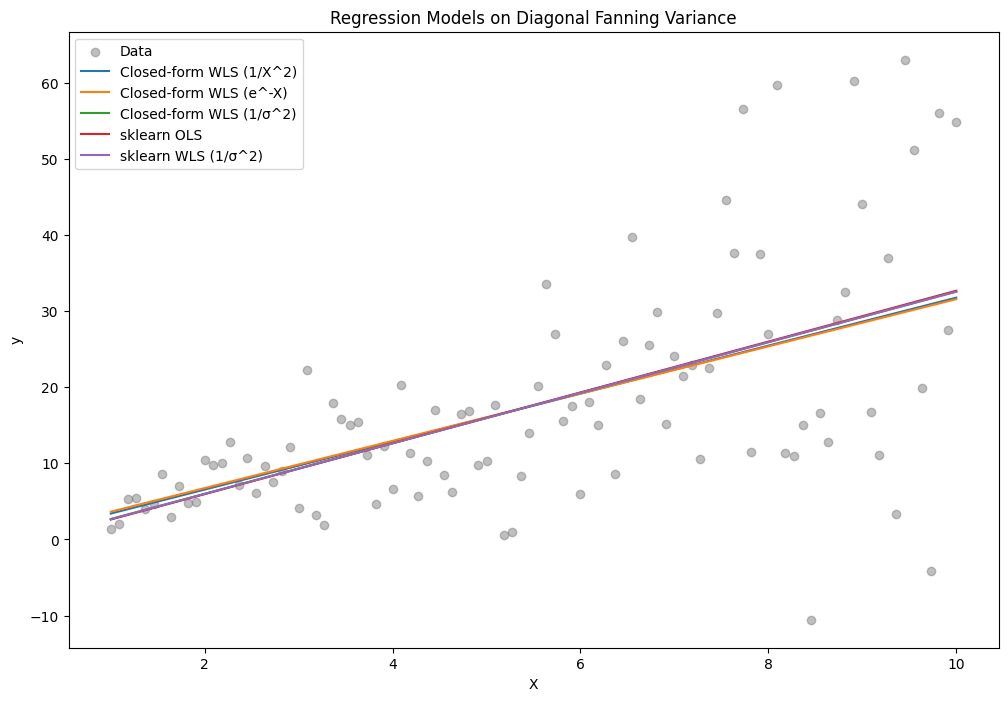

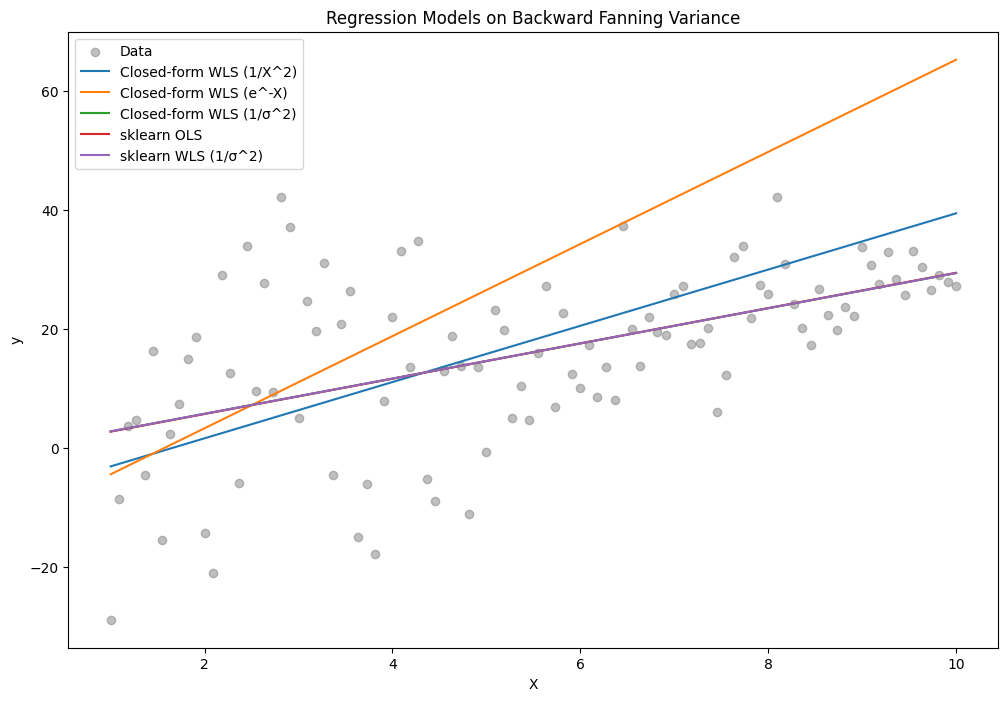

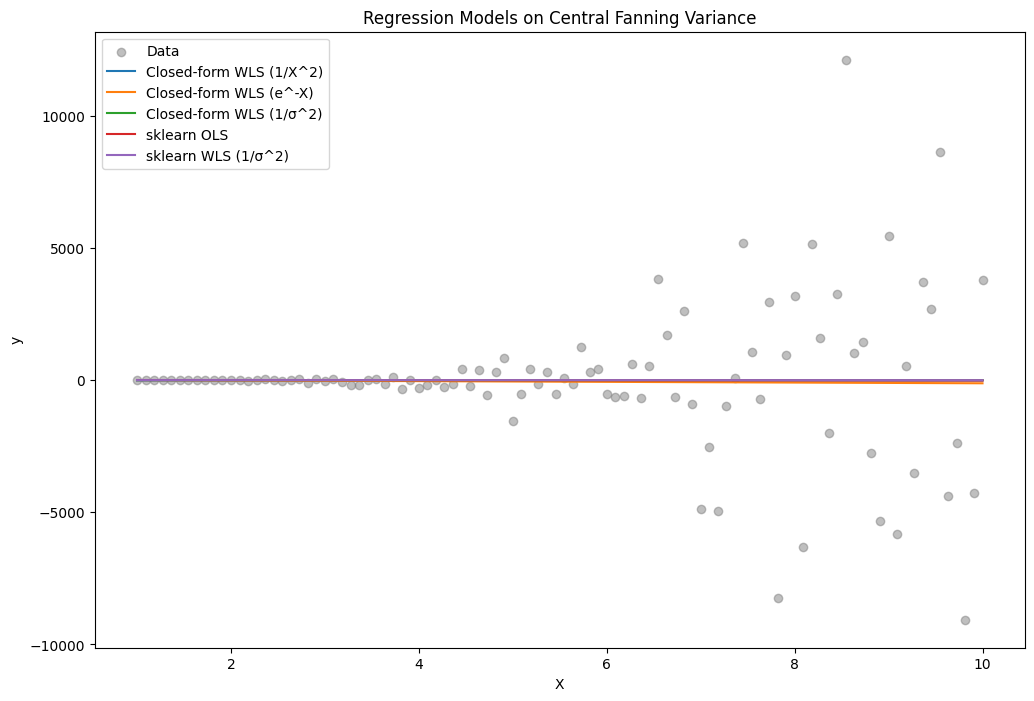

In [52]:
# Generate datasets for three different patterns
patterns = ["diagonal", "backward", "central"]
datasets = {pattern: generate_fanning_data(pattern) for pattern in patterns}

# Fit models and plot results for each pattern
all_betas = []

for pattern, (X, y) in datasets.items():
    results = fit_models(X, y)
    
    # Plot data and models
    plt.figure(figsize=(12, 8))
    plt.scatter(X, y, color="gray", alpha=0.5, label="Data")
    
    # Plot each model
    for model_name, (y_pred, beta) in results.items():
        plt.plot(X, y_pred, label=model_name)
        all_betas.append((pattern, model_name, beta[0], beta[1]))
    
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.title(f"Regression Models on {pattern.capitalize()} Fanning Variance")
    plt.show()

In [54]:
# Create a DataFrame to display intercept and coefficients for each model
beta_df = pd.DataFrame(all_betas, columns=["Pattern", "Model", "Intercept", "Coefficient"])

beta_df

,Pattern,Model,Intercept,Coefficient
0,diagonal,Closed-form WLS (1/X^2),0.244782,3.150316
1,diagonal,Closed-form WLS (e^-X),0.538270,3.101382
2,diagonal,Closed-form WLS (1/σ^2),-0.655880,3.319395
3,diagonal,sklearn OLS,-0.731136,3.339050
4,diagonal,sklearn WLS (1/σ^2),-0.655880,3.319395
5,backward,Closed-form WLS (1/X^2),-7.857114,4.724390
6,backward,Closed-form WLS (e^-X),-12.194472,7.738275
7,backward,Closed-form WLS (1/σ^2),-0.199478,2.955220
8,backward,sklearn OLS,-0.254599,2.964363
9,backward,sklearn WLS (1/σ^2),-0.199478,2.955220


# Question 6

In [57]:
import numpy as np

# Dataset given
X = np.array([[2, 3], [1, 1], [4, 4], [5, 5], [6, 7], [7, 8]]) 
y = np.array([1, 1, -1, -1, -1, 1])

# Point to classify
point = np.array([3, 4])

# Calculate Euclidean distances from the point to all points in X
distances = np.sqrt(np.sum((X - point)**2, axis=1))

# Combine distances with labels for easier sorting
distances_with_labels = np.column_stack((distances, y))

# Sort by distances
sorted_distances = distances_with_labels[distances_with_labels[:, 0].argsort()]

# Function to perform majority voting
def majority_vote(sorted_distances, k):
    # Take the first k elements and perform majority vote
    top_k = sorted_distances[:k, 1]
    values, counts = np.unique(top_k, return_counts=True)
    majority_class = values[np.argmax(counts)]
    return majority_class

# Predictions for k=1, 3, 5
k_values = [1, 3, 5]
predictions = [majority_vote(sorted_distances, k) for k in k_values]

In [59]:
distances

array([1.41421356, 3.60555128, 1.        , 2.23606798, 4.24264069,
       5.65685425])

In [56]:
predictions

[-1.0, -1.0, -1.0]

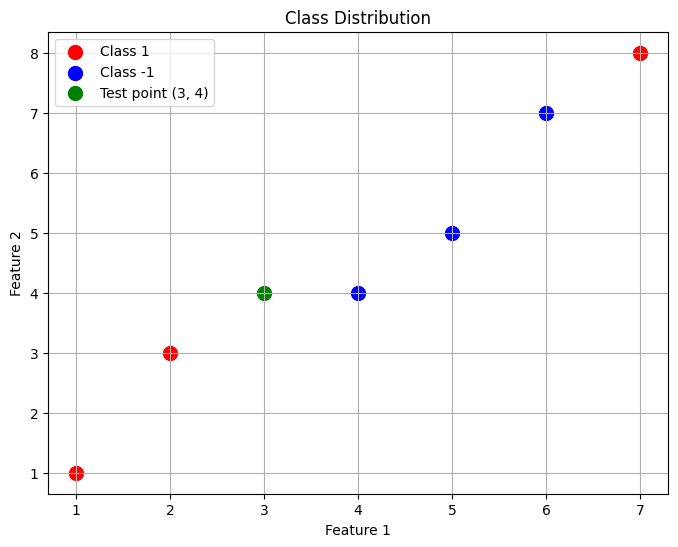

In [63]:
# Plotting the dataset with class color distinctions
fig, ax = plt.subplots(figsize=(8, 6))

# Plot all points with their class colors
for j in range(len(X)):
    ax.scatter(*X[j], color='red' if y[j] == 1 else 'blue', s=100, label=f'Class {y[j]}' if j in [0, 2] else "")
    
# Plot the test point
ax.scatter(*point, color='green', s=100, label='Test point (3, 4)')

ax.set_title('Class Distribution')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid(True)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # removing duplicates
ax.legend(by_label.values(), by_label.keys())

plt.show()

In [68]:
from sklearn.neighbors import KNeighborsClassifier

classifiers = {k: KNeighborsClassifier(n_neighbors=k, weights='distance') for k in [1, 3, 5]}

fits = {k: clf.fit(X, y) for k, clf in classifiers.items()}
pred = {k: clf.predict([point])[0] for k, clf in fits.items()}
pred

{1: -1, 3: -1, 5: -1}

In [70]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

iris = load_iris()  
X = iris.data  
y = iris.target # Split the data into training and testing sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
# Initialize and fit k-NN classifiers for k=1, 3, 5 on Iris dataset
iris_classifiers = {k: KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train) for k in k_values}

# Predict on the test set and calculate accuracy
iris_accuracies = {k: accuracy_score(y_test, clf.predict(X_test)) for k, clf in iris_classifiers.items()}
iris_accuracies

{1: 1.0, 3: 1.0, 5: 1.0}

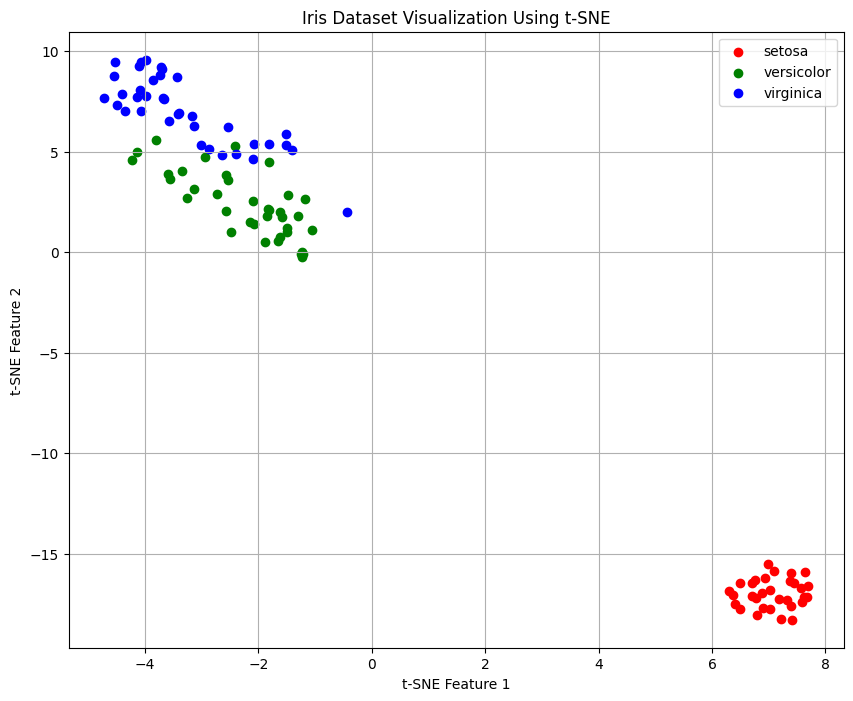

In [78]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto', n_iter=1000)
X_iris_tsne = tsne.fit_transform(X_train)

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    plt.scatter(X_iris_tsne[y_train == i, 0], X_iris_tsne[y_train == i, 1], c=color, label=iris.target_names[i])

plt.title('Iris Dataset Visualization Using t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.grid(True)
plt.show()

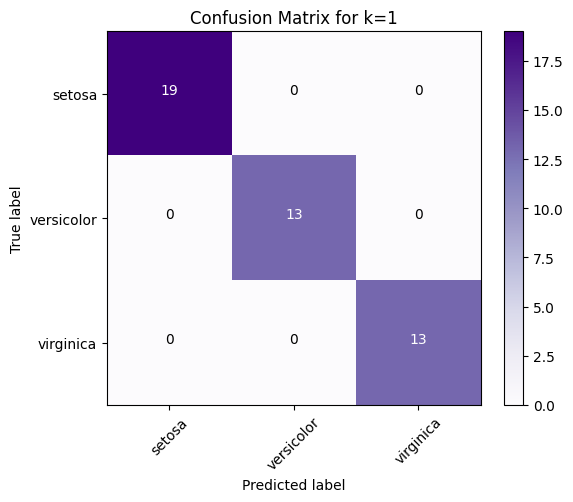

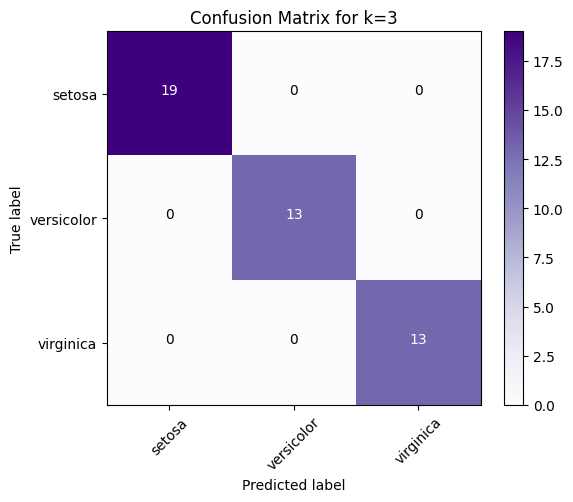

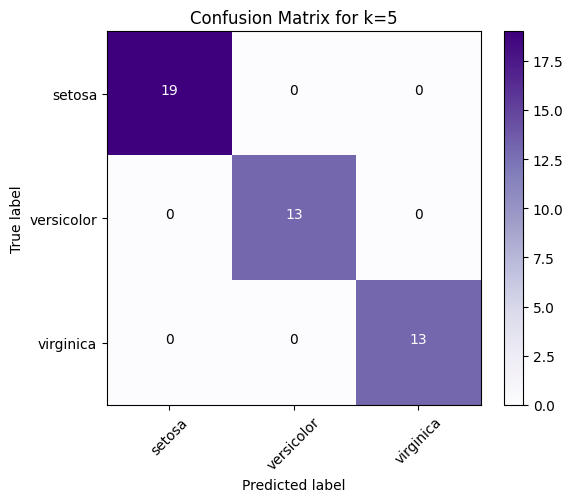

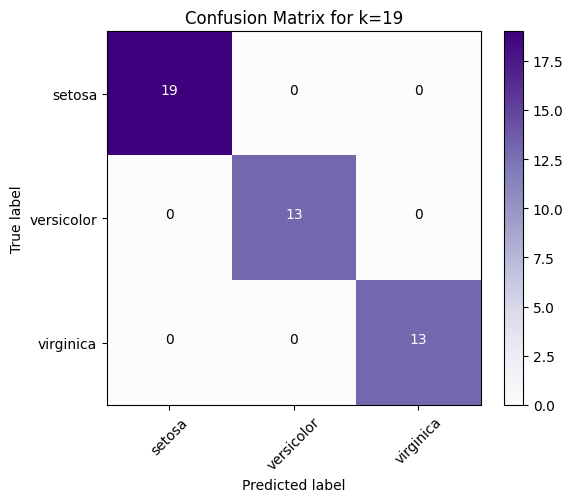

Confusion Matrix for k=1:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=1: 1.0

Confusion Matrix for k=3:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=3: 1.0

Confusion Matrix for k=5:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=5: 1.0

Confusion Matrix for k=19:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=19: 1.0



In [88]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the values of k
k_values = [1, 3, 5, 19]

# Initialize dictionary to store models
models = {}

# Train k-NN models for each k and compute confusion matrices
confusion_matrices = {}
accuracies = {}

for k in k_values:
    # Initialize the KNeighbors classifier with k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train the classifier
    knn.fit(X_train, y_train)
    
    # Store the model
    models[k] = knn
    
    # Predict the test set results
    y_pred = knn.predict(X_test)
    
    # Compute and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[k] = cm

    acc = accuracy_score(y_test, y_pred)
    accuracies[k] = acc
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    plt.title(f'Confusion Matrix for k={k}')
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    
    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrices for each k
for k, cm in confusion_matrices.items():
    print(f"Confusion Matrix for k={k}:\n{cm}\n")
    print(f"Accuracy for k={k}: {accuracies[k]}\n")

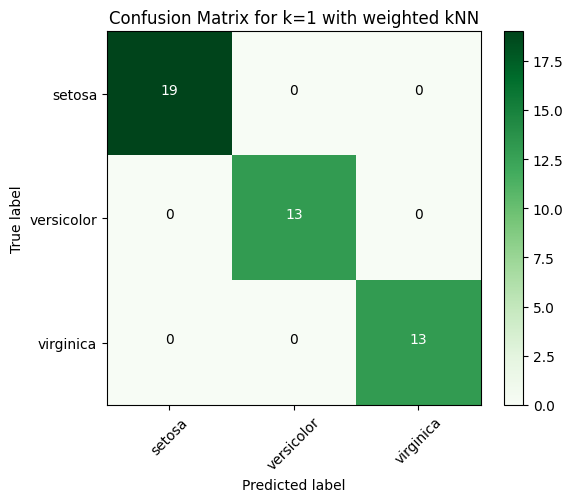

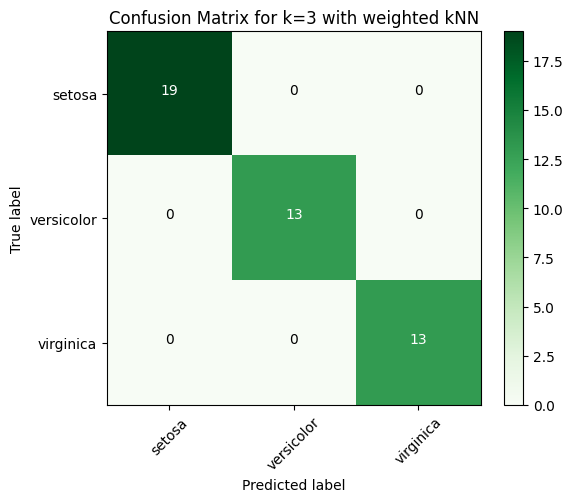

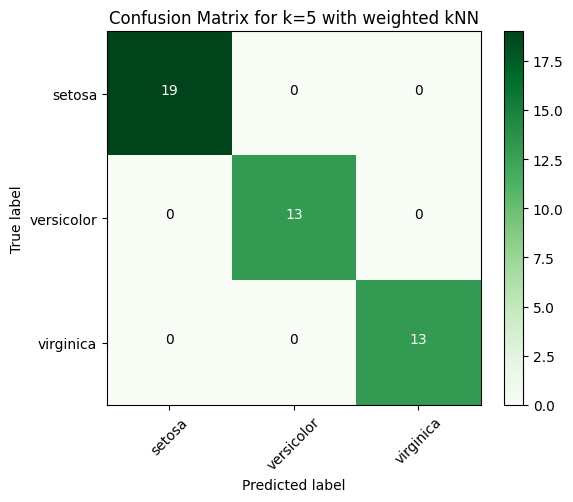

Confusion Matrix for k=1:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=1: 1.0

Confusion Matrix for k=3:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=3: 1.0

Confusion Matrix for k=5:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]

Accuracy for k=5: 1.0



In [86]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the values of k
k_values = [1, 3, 5]

# Initialize dictionary to store models
models = {}

# Train k-NN models for each k and compute confusion matrices
confusion_matrices = {}
accuracies = {}

for k in k_values:
    # Initialize the KNeighbors classifier with k
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    # Train the classifier
    knn.fit(X_train, y_train)
    
    # Store the model
    models[k] = knn
    
    # Predict the test set results
    y_pred = knn.predict(X_test)
    
    # Compute and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[k] = cm

    acc = accuracy_score(y_test, y_pred)
    accuracies[k] = acc
    
    # Plotting confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(f'Confusion Matrix for k={k} with weighted kNN')
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    
    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrices for each k
for k, cm in confusion_matrices.items():
    print(f"Confusion Matrix for k={k}:\n{cm}\n")
    print(f"Accuracy for k={k}: {accuracies[k]}\n")

# Question 8

### part a and b

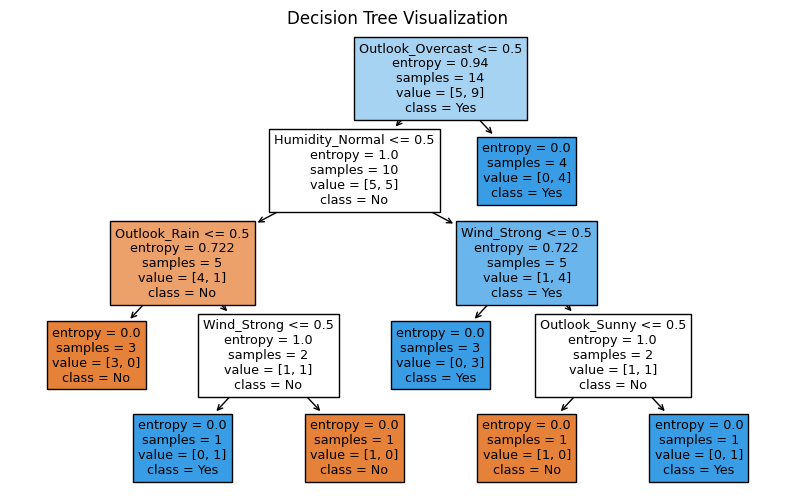

In [135]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

# Sample dataset
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

# Encode categorical features
df = pd.DataFrame(data)
df = pd.get_dummies(df, columns=['Outlook', 'Temp', 'Humidity', 'Wind'])
y = df['Tennis'].apply(lambda x: 1 if x == 'Yes' else 0)
X = df.drop(columns=['Tennis'])

# Train Decision Tree with max depth 1 to illustrate the Outlook split only
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(10, 6))
plot_tree(clf, feature_names=X.columns, class_names=['No', 'Yes'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [94]:
import numpy as np
import pandas as pd

# Original dataset
data = {
    'Day': range(1, 15),
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)
df

,Day,Outlook,Temp,Humidity,Wind,Tennis
0,1,Sunny,Hot,High,Weak,No
1,2,Sunny,Hot,High,Strong,No
2,3,Overcast,Hot,High,Weak,Yes
3,4,Rain,Mild,High,Weak,Yes
4,5,Rain,Cool,Normal,Weak,Yes
5,6,Rain,Cool,Normal,Strong,No
6,7,Overcast,Cool,Normal,Strong,Yes
7,8,Sunny,Mild,High,Weak,No
8,9,Sunny,Cool,Normal,Weak,Yes
9,10,Rain,Mild,Normal,Weak,Yes


In [112]:
def count_yes_no_by_attribute(df, column_name):
    # Group by the specified column and count 'Yes' and 'No' for each attribute
    grouped = df.groupby([column_name, 'Tennis']).size().unstack(fill_value=0)
    
    # Print the counts for each attribute in the specified column
    for attribute, counts in grouped.iterrows():
        yes_count = counts.get('Yes', 0)
        no_count = counts.get('No', 0)
        print(f"{column_name} = {attribute}: 'Yes' instances = {yes_count}, 'No' instances = {no_count}")

# Function to calculate entropy
def entropy(target_column):
    values, counts = np.unique(target_column, return_counts=True)
    probabilities = counts / counts.sum()
    return -sum(probabilities * np.log2(probabilities))

# Calculate the entropy of the whole dataset
H_N = entropy(df['Tennis'])
print(f"Entropy of the target (Tennis): H(N) = {H_N:.3f}\n")

# Function to calculate information gain
def information_gain(df, split_attribute, root_entropy, target_attribute='Tennis'):
    # Calculate the weighted entropy
    values, counts = np.unique(df[split_attribute], return_counts=True)
    weighted_entropy = sum(
        (counts[i] / sum(counts)) * entropy(df[df[split_attribute] == values[i]][target_attribute])
        for i in range(len(values))
    )
    print(f'weighted_entropy of {split_attribute} = {weighted_entropy:.3f}')
    # Calculate information gain
    return root_entropy - weighted_entropy

# Calculate and print information gain for each attribute
attributes = ['Outlook', 'Temp', 'Humidity', 'Wind']
for attribute in attributes:
    ig = information_gain(df, attribute, H_N)
    count_yes_no_by_attribute(df, attribute)
    print(f"Information Gain for {attribute}: IG(N, {attribute}) = {ig:.3f}\n")

Entropy of the target (Tennis): H(N) = 0.940

weighted_entropy of Outlook = 0.694
Outlook = Overcast: 'Yes' instances = 4, 'No' instances = 0
Outlook = Rain: 'Yes' instances = 3, 'No' instances = 2
Outlook = Sunny: 'Yes' instances = 2, 'No' instances = 3
Information Gain for Outlook: IG(N, Outlook) = 0.247

weighted_entropy of Temp = 0.911
Temp = Cool: 'Yes' instances = 3, 'No' instances = 1
Temp = Hot: 'Yes' instances = 2, 'No' instances = 2
Temp = Mild: 'Yes' instances = 4, 'No' instances = 2
Information Gain for Temp: IG(N, Temp) = 0.029

weighted_entropy of Humidity = 0.788
Humidity = High: 'Yes' instances = 3, 'No' instances = 4
Humidity = Normal: 'Yes' instances = 6, 'No' instances = 1
Information Gain for Humidity: IG(N, Humidity) = 0.152

weighted_entropy of Wind = 0.892
Wind = Strong: 'Yes' instances = 3, 'No' instances = 3
Wind = Weak: 'Yes' instances = 6, 'No' instances = 2
Information Gain for Wind: IG(N, Wind) = 0.048



In [113]:
# Remove all rows where Outlook is "Overcast"
df_no_overcast = df[df['Outlook'] != 'Overcast']
df_no_overcast

,Day,Outlook,Temp,Humidity,Wind,Tennis
0,1,Sunny,Hot,High,Weak,No
1,2,Sunny,Hot,High,Strong,No
3,4,Rain,Mild,High,Weak,Yes
4,5,Rain,Cool,Normal,Weak,Yes
5,6,Rain,Cool,Normal,Strong,No
7,8,Sunny,Mild,High,Weak,No
8,9,Sunny,Cool,Normal,Weak,Yes
9,10,Rain,Mild,Normal,Weak,Yes
10,11,Sunny,Mild,Normal,Strong,Yes
13,14,Rain,Mild,High,Strong,No


In [115]:
# Recalculate the entropy of the target variable in the updated dataset
H_N_no_overcast = entropy(df_no_overcast['Tennis'])
print(f"Entropy of the target (Tennis) after removing 'Overcast' rows: H(N) = {H_N_no_overcast:.3f}")

# Recalculate and print information gain for each attribute in the updated dataset
for attribute in ['Outlook', 'Temp', 'Humidity', 'Wind']:
    ig_no_overcast = information_gain(df_no_overcast, attribute, H_N_no_overcast)
    count_yes_no_by_attribute(df_no_overcast, attribute)
    print(f"Information Gain for {attribute} after removing 'Overcast' rows: IG(N, {attribute}) = {ig_no_overcast:.3f}\n")

Entropy of the target (Tennis) after removing 'Overcast' rows: H(N) = 1.000
weighted_entropy of Outlook = 0.971
Outlook = Rain: 'Yes' instances = 3, 'No' instances = 2
Outlook = Sunny: 'Yes' instances = 2, 'No' instances = 3
Information Gain for Outlook after removing 'Overcast' rows: IG(N, Outlook) = 0.029

weighted_entropy of Temp = 0.761
Temp = Cool: 'Yes' instances = 2, 'No' instances = 1
Temp = Hot: 'Yes' instances = 0, 'No' instances = 2
Temp = Mild: 'Yes' instances = 3, 'No' instances = 2
Information Gain for Temp after removing 'Overcast' rows: IG(N, Temp) = 0.239

weighted_entropy of Humidity = 0.722
Humidity = High: 'Yes' instances = 1, 'No' instances = 4
Humidity = Normal: 'Yes' instances = 4, 'No' instances = 1
Information Gain for Humidity after removing 'Overcast' rows: IG(N, Humidity) = 0.278

weighted_entropy of Wind = 0.875
Wind = Strong: 'Yes' instances = 1, 'No' instances = 3
Wind = Weak: 'Yes' instances = 4, 'No' instances = 2
Information Gain for Wind after removin

In [120]:
import numpy as np
import pandas as pd

# Original dataset
data = {
    'Day': range(1, 15),
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)

# Function to calculate entropy
def entropy(target_column):
    values, counts = np.unique(target_column, return_counts=True)
    probabilities = counts / counts.sum()
    return -sum(probabilities * np.log2(probabilities))

# Function to calculate information gain
def information_gain(df, split_attribute, target_attribute='Tennis'):
    total_entropy = entropy(df[target_attribute])
    values, counts = np.unique(df[split_attribute], return_counts=True)
    
    weighted_entropy = sum(
        (counts[i] / sum(counts)) * entropy(df[df[split_attribute] == values[i]][target_attribute])
        for i in range(len(values))
    )
    info_gain = total_entropy - weighted_entropy
    return info_gain, weighted_entropy

# Function to print data subset, entropy, and information gain details
def print_split_info(df, split_attribute, target_attribute='Tennis'):
    print(f"\nData Subset for splitting by {split_attribute}:")
    # print(df)
    total_entropy = entropy(df[target_attribute])
    print(f"Entropy of node: H({split_attribute}) = {total_entropy:.3f}")
    
    info_gain, weighted_entropy = information_gain(df, split_attribute, target_attribute)
    print(f"Weighted Entropy for {split_attribute}: {weighted_entropy:.3f}")
    print(f"Information Gain for {split_attribute}: IG(N, {split_attribute}) = {info_gain:.3f}")

# Recursive function to build decision tree
def build_tree(df, target_attribute='Tennis', depth=0):
    print("\n" + "="*20 + f" Depth {depth} " + "="*20)
    # Print the current subset of data
    print("Current data subset:")
    # print(df)

    # Check for a pure split or empty dataset
    if len(np.unique(df[target_attribute])) == 1:
        classification = df[target_attribute].iloc[0]
        print(f"Leaf Node: {classification} (Pure node)")
        return classification

    elif df.empty:
        print("Leaf Node: No data available")
        return None

    # Calculate information gain for each attribute
    gains = {}
    for column in df.columns:
        if column != target_attribute and column != 'Day':
            gain, _ = information_gain(df, column, target_attribute)
            gains[column] = gain
            print_split_info(df, column, target_attribute)

    # Select the attribute with the highest information gain
    best_split = max(gains, key=gains.get)
    print(f"\nBest attribute to split on: {best_split}")
    
    # Recursive splitting
    tree = {best_split: {}}
    for value in df[best_split].unique():
        subset = df[df[best_split] == value].drop(columns=[best_split])
        print(f"\nCreating subtree for {best_split} = {value}")
        tree[best_split][value] = build_tree(subset, target_attribute, depth + 1)
    
    return tree

In [124]:
import numpy as np
import pandas as pd

# Original dataset
data = {
    'Day': range(1, 15),
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)

# Function to calculate entropy
def entropy(target_column):
    values, counts = np.unique(target_column, return_counts=True)
    probabilities = counts / counts.sum()
    return -sum(probabilities * np.log2(probabilities))

# Function to calculate information gain for a binary split
def binary_information_gain(df, split_attribute, value, target_attribute='Tennis'):
    total_entropy = entropy(df[target_attribute])
    
    subset1 = df[df[split_attribute] == value]
    subset2 = df[df[split_attribute] != value]
    
    weighted_entropy = (
        (len(subset1) / len(df)) * entropy(subset1[target_attribute]) +
        (len(subset2) / len(df)) * entropy(subset2[target_attribute])
    )
    info_gain = total_entropy - weighted_entropy
    return info_gain, weighted_entropy, subset1, subset2

# Function to print data subsets, entropy, and information gain details
def print_split_info(df, split_attribute, value, target_attribute='Tennis'):
    print(f"\nTrying binary split on {split_attribute} = {value}")
    total_entropy = entropy(df[target_attribute])
    print(f"Entropy of node: H({split_attribute}) = {total_entropy:.3f}")
    
    info_gain, weighted_entropy, subset1, subset2 = binary_information_gain(df, split_attribute, value, target_attribute)
    # print(f"Subset where {split_attribute} = {value}:")
    # print(subset1)
    # print(f"Subset where {split_attribute} != {value}:")
    # print(subset2)
    print(f"Weighted Entropy for {split_attribute} = {value}: {weighted_entropy:.3f}")
    print(f"Information Gain for {split_attribute} = {value}: IG(N, {split_attribute}) = {info_gain:.3f}")
    return info_gain, subset1, subset2

# Recursive function to build decision tree with binary splits
def build_tree(df, target_attribute='Tennis', depth=0):
    print("\n" + "="*20 + f" Depth {depth} " + "="*20)
    # print("Current data subset:")
    # print(df)

    # Check for a pure split or empty dataset
    if len(np.unique(df[target_attribute])) == 1:
        classification = df[target_attribute].iloc[0]
        print(f"Leaf Node: {classification} (Pure node)")
        return classification

    elif df.empty:
        print("Leaf Node: No data available")
        return None

    # Find the best binary split
    best_gain = -1
    best_split = None
    best_subset1, best_subset2 = None, None
    
    for column in df.columns:
        if column != target_attribute and column != 'Day':
            unique_values = df[column].unique()
            for value in unique_values:
                info_gain, subset1, subset2 = print_split_info(df, column, value, target_attribute)
                if info_gain > best_gain:
                    best_gain = info_gain
                    best_split = (column, value)
                    best_subset1, best_subset2 = subset1, subset2

    if best_split is None:
        print("No valid split found.")
        return None

    split_attribute, split_value = best_split
    print(f"\nBest binary split: {split_attribute} = {split_value} with Information Gain = {best_gain:.3f}")

    # Recursively build the tree
    tree = {f"{split_attribute} = {split_value}": {}}
    tree[f"{split_attribute} = {split_value}"]['Yes'] = build_tree(best_subset1.drop(columns=[split_attribute]), target_attribute, depth + 1)
    tree[f"{split_attribute} = {split_value}"]['No'] = build_tree(best_subset2.drop(columns=[split_attribute]), target_attribute, depth + 1)
    
    return tree

# Build and display the decision tree
decision_tree = build_tree(df)
print("\nConstructed Decision Tree:")
print(decision_tree)



==================== Depth 0 ====================

Trying binary split on Outlook = Sunny
Entropy of node: H(Outlook) = 0.940
Weighted Entropy for Outlook = Sunny: 0.838
Information Gain for Outlook = Sunny: IG(N, Outlook) = 0.102

Trying binary split on Outlook = Overcast
Entropy of node: H(Outlook) = 0.940
Weighted Entropy for Outlook = Overcast: 0.714
Information Gain for Outlook = Overcast: IG(N, Outlook) = 0.226

Trying binary split on Outlook = Rain
Entropy of node: H(Outlook) = 0.940
Weighted Entropy for Outlook = Rain: 0.937
Information Gain for Outlook = Rain: IG(N, Outlook) = 0.003

Trying binary split on Temp = Hot
Entropy of node: H(Temp) = 0.940
Weighted Entropy for Temp = Hot: 0.915
Information Gain for Temp = Hot: IG(N, Temp) = 0.025

Trying binary split on Temp = Mild
Entropy of node: H(Temp) = 0.940
Weighted Entropy for Temp = Mild: 0.939
Information Gain for Temp = Mild: IG(N, Temp) = 0.001

Trying binary split on Temp = Cool
Entropy of node: H(Temp) = 0.940
Weighted

In [138]:
import numpy as np
import pandas as pd

# Original dataset
data = {
    'Day': range(1, 15),
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temp': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}
df = pd.DataFrame(data)

# Function to calculate entropy
def entropy(target_column):
    values, counts = np.unique(target_column, return_counts=True)
    probabilities = counts / counts.sum()
    return -sum(probabilities * np.log2(probabilities))

# Function to calculate information gain and print details in the specified format
def calculate_and_print_information_gain(df, target_attribute='Tennis'):
    total_entropy = entropy(df[target_attribute])
    print(f"Total entropy of the node: H(N) = {total_entropy:.3f}")

    for attribute in [col for col in df.columns if col != target_attribute and col != 'Day']:
        unique_values = df[attribute].unique()
        weighted_entropy = 0
        print(f"\n\\textbf{{{attribute}}}:")

        for value in unique_values:
            subset = df[df[attribute] == value]
            subset_entropy = entropy(subset[target_attribute])
            weight = len(subset) / len(df)
            weighted_entropy += weight * subset_entropy
            print(f"    \\item $H(N_{{\\text{{{value}}}}}) = {subset_entropy:.3f}$")

        info_gain = total_entropy - weighted_entropy
        print(f"    \\item Weighted entropy $H(\\text{{{attribute}}}) = {weighted_entropy:.3f}$")
        print(f"    \\item $IG(N, \\text{{{attribute}}}) = {total_entropy:.3f} - {weighted_entropy:.3f} = {info_gain:.3f}$\n")

# Recursive function to build decision tree with binary splits
def build_tree(df, target_attribute='Tennis', depth=0):
    print("\n" + "="*20 + f" Depth {depth} " + "="*20)
    print("Current data subset:")
    print(df)

    # Check for a pure split or empty dataset
    if len(np.unique(df[target_attribute])) == 1:
        classification = df[target_attribute].iloc[0]
        print(f"Leaf Node: {classification} (Pure node)")
        return classification

    elif df.empty:
        print("Leaf Node: No data available")
        return None

    # Calculate information gain for each attribute and print details
    calculate_and_print_information_gain(df, target_attribute)

    # Find the best split based on information gain
    best_gain = -1
    best_split = None
    best_subset1, best_subset2 = None, None

    for column in [col for col in df.columns if col != target_attribute and col != 'Day']:
        unique_values = df[column].unique()
        for value in unique_values:
            subset1 = df[df[column] == value]
            subset2 = df[df[column] != value]
            weight1 = len(subset1) / len(df)
            weight2 = len(subset2) / len(df)
            weighted_entropy = (weight1 * entropy(subset1[target_attribute]) +
                                weight2 * entropy(subset2[target_attribute]))
            info_gain = entropy(df[target_attribute]) - weighted_entropy

            if info_gain > best_gain:
                best_gain = info_gain
                best_split = (column, value)
                best_subset1, best_subset2 = subset1, subset2

    if best_split is None:
        print("No valid split found.")
        return None

    split_attribute, split_value = best_split
    print(f"\nBest binary split: {split_attribute} == {split_value} with Information Gain = {best_gain:.3f}")

    # Remove rows where the split condition is met for further splits
    best_subset1 = best_subset1.drop(best_subset1[best_subset1[split_attribute] == split_value].index)
    best_subset2 = best_subset2.drop(best_subset2[best_subset2[split_attribute] == split_value].index)

    # Recursively build the tree
    tree = {f"{split_attribute} == {split_value}": {}}
    tree[f"{split_attribute} == {split_value}"]['Yes'] = build_tree(best_subset1, target_attribute, depth + 1)
    tree[f"{split_attribute} == {split_value}"]['No'] = build_tree(best_subset2, target_attribute, depth + 1)
    
    return tree

In [139]:
# Build and display the decision tree
decision_tree = build_tree(df)
print("\nConstructed Decision Tree:")
import pprint
pprint.pprint(decision_tree)


==================== Depth 0 ====================
Current data subset:
    Day   Outlook  Temp Humidity    Wind Tennis
0     1     Sunny   Hot     High    Weak     No
1     2     Sunny   Hot     High  Strong     No
2     3  Overcast   Hot     High    Weak    Yes
3     4      Rain  Mild     High    Weak    Yes
4     5      Rain  Cool   Normal    Weak    Yes
5     6      Rain  Cool   Normal  Strong     No
6     7  Overcast  Cool   Normal  Strong    Yes
7     8     Sunny  Mild     High    Weak     No
8     9     Sunny  Cool   Normal    Weak    Yes
9    10      Rain  Mild   Normal    Weak    Yes
10   11     Sunny  Mild   Normal  Strong    Yes
11   12  Overcast  Mild     High  Strong    Yes
12   13  Overcast   Hot   Normal    Weak    Yes
13   14      Rain  Mild     High  Strong     No
Total entropy of the node: H(N) = 0.940

\textbf{Outlook}:
    \item $H(N_{\text{Sunny}}) = 0.971$
    \item $H(N_{\text{Overcast}}) = -0.000$
    \item $H(N_{\text{Rain}}) = 0.971$
    \item Weighted entropy

In [142]:
import pandas as pd
import numpy as np

# Define dataset
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate entropy
def entropy(column):
    counts = column.value_counts()
    probabilities = counts / len(column)
    return -sum(probabilities * np.log2(probabilities))

# Calculate the overall entropy of the target column
def overall_entropy(df):
    return entropy(df['Tennis'])

# Calculate information gain for a specific feature
def info_gain(df, feature):
    total_entropy = overall_entropy(df)
    values = df[feature].unique()
    weighted_entropy = 0
    for value in values:
        subset = df[df[feature] == value]
        subset_entropy = entropy(subset['Tennis'])
        weighted_entropy += (len(subset) / len(df)) * subset_entropy
        print(f"  - H(N_{value}) = {subset_entropy:.3f}")
    info_gain = total_entropy - weighted_entropy
    print(f"  - Weighted entropy H({feature}) = {weighted_entropy:.3f}")
    print(f"  - IG(N, {feature}) = {total_entropy:.3f} - {weighted_entropy:.3f} = {info_gain:.3f}")
    return info_gain

# Function to build the decision tree
def build_tree(df, features):
    if len(df['Tennis'].unique()) == 1:
        return df['Tennis'].iloc[0]
    if len(features) == 0:
        return df['Tennis'].mode()[0]
    
    # Calculate information gain for each feature
    print("\nCalculating Information Gain:")
    gains = {}
    for feature in features:
        print(f"Feature: {feature}")
        gains[feature] = info_gain(df, feature)
    
    # Choose the feature with the highest information gain
    best_feature = max(gains, key=gains.get)
    print(f"\nBest feature: {best_feature} with IG = {gains[best_feature]:.3f}")
    
    # Create a subtree for each unique value in the best feature
    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]
    
    for value in df[best_feature].unique():
        subset = df[df[best_feature] == value]
        print(f'\nBuilding tree with value == {value}...')
        subtree = build_tree(subset, remaining_features)
        tree[best_feature][value] = subtree
    
    return tree

# List of features to consider
features = ['Outlook', 'Temperature', 'Humidity', 'Wind']

# Build the decision tree
decision_tree = build_tree(df, features)
print("\nDecision Tree:")
print(decision_tree)


Calculating Information Gain:
Feature: Outlook
  - H(N_Sunny) = 0.971
  - H(N_Overcast) = -0.000
  - H(N_Rain) = 0.971
  - Weighted entropy H(Outlook) = 0.694
  - IG(N, Outlook) = 0.940 - 0.694 = 0.247
Feature: Temperature
  - H(N_Hot) = 1.000
  - H(N_Mild) = 0.918
  - H(N_Cool) = 0.811
  - Weighted entropy H(Temperature) = 0.911
  - IG(N, Temperature) = 0.940 - 0.911 = 0.029
Feature: Humidity
  - H(N_High) = 0.985
  - H(N_Normal) = 0.592
  - Weighted entropy H(Humidity) = 0.788
  - IG(N, Humidity) = 0.940 - 0.788 = 0.152
Feature: Wind
  - H(N_Weak) = 0.811
  - H(N_Strong) = 1.000
  - Weighted entropy H(Wind) = 0.892
  - IG(N, Wind) = 0.940 - 0.892 = 0.048

Best feature: Outlook with IG = 0.247

Building tree with value == Sunny...

Calculating Information Gain:
Feature: Temperature
  - H(N_Hot) = -0.000
  - H(N_Mild) = 1.000
  - H(N_Cool) = -0.000
  - Weighted entropy H(Temperature) = 0.400
  - IG(N, Temperature) = 0.971 - 0.400 = 0.571
Feature: Humidity
  - H(N_High) = -0.000
  - H(

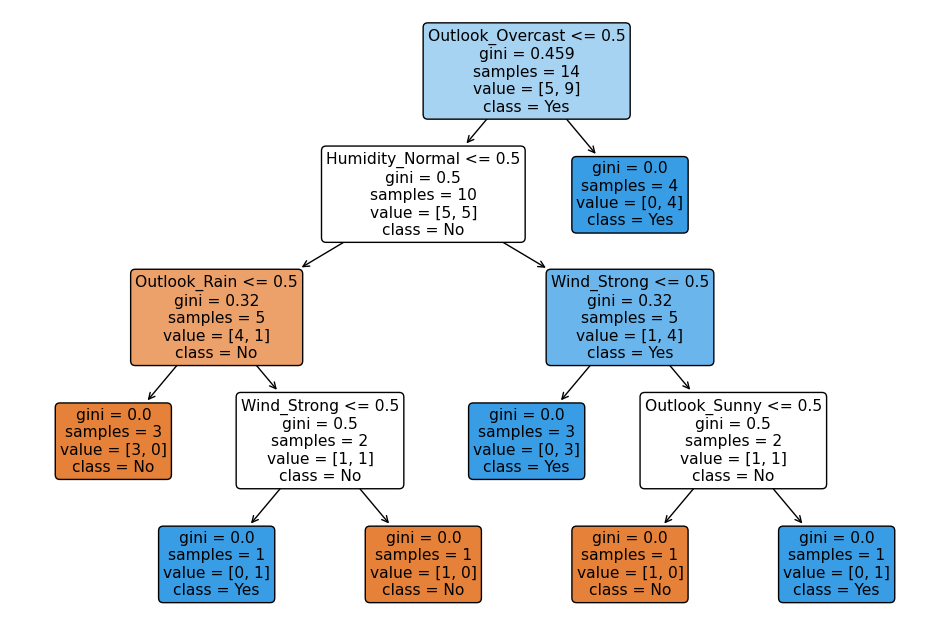

In [171]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Define dataset
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Encode categorical variables
df_encoded = pd.get_dummies(df[['Outlook', 'Temperature', 'Humidity', 'Wind']])
y = df['Tennis'].map({'Yes': 1, 'No': 0})  # Encode target variable

# Train a decision tree classifier
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(df_encoded, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df_encoded.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

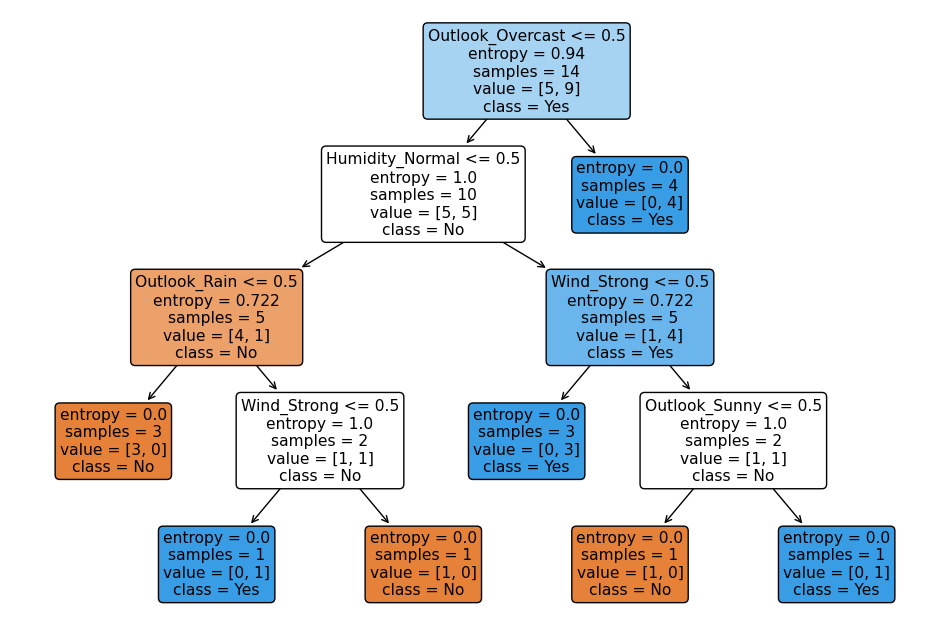

In [172]:
# Train a decision tree classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(df_encoded, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=df_encoded.columns, class_names=['No', 'Yes'], filled=True, rounded=True)
plt.show()

In [164]:
import pandas as pd
import numpy as np

# Define dataset
data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rain', 'Rain', 'Rain', 'Overcast', 'Sunny', 'Sunny', 'Rain', 'Sunny', 'Overcast', 'Overcast', 'Rain'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Weak', 'Strong', 'Strong', 'Weak', 'Strong'],
    'Tennis': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate Gini impurity
def gini_impurity(column):
    counts = column.value_counts()
    probabilities = counts / len(column)
    return 1 - sum(probabilities ** 2)

# Calculate the weighted Gini impurity for a specific feature
def weighted_gini(df, feature):
    values = df[feature].unique()
    weighted_gini = 0
    for value in values:
        subset = df[df[feature] == value]
        subset_gini = gini_impurity(subset['Tennis'])
        weighted_gini += (len(subset) / len(df)) * subset_gini
        print(f"  - Gini(N_{value}) = {subset_gini:.3f}")
    print(f"  - Weighted Gini H({feature}) = {weighted_gini:.3f}")
    return weighted_gini

# Function to build the decision tree
def build_tree(df, features):
    if len(df['Tennis'].unique()) == 1:
        return df['Tennis'].iloc[0]
    if len(features) == 0:
        return df['Tennis'].mode()[0]
    
    # Calculate weighted Gini for each feature
    print("\nCalculating Weighted Gini:")
    gini_values = {}
    for feature in features:
        print(f"Feature: {feature}")
        gini_values[feature] = weighted_gini(df, feature)
    
    # Choose the feature with the lowest weighted Gini impurity
    best_feature = min(gini_values, key=gini_values.get)
    print(f"\nBest feature: {best_feature} with Gini = {gini_values[best_feature]:.3f}")
    
    # Create a subtree for each unique value in the best feature
    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]
    
    for value in df[best_feature].unique():
        subset = df[df[best_feature] == value]
        print(f'\nBuilding tree based on value == {value}...')
        subtree = build_tree(subset, remaining_features)
        tree[best_feature][value] = subtree
    
    return tree

# List of features to consider
features = ['Outlook', 'Temperature', 'Humidity', 'Wind']

# Build the decision tree
decision_tree = build_tree(df, features)
print("\nDecision Tree:")
print(decision_tree)


Calculating Weighted Gini:
Feature: Outlook
  - Gini(N_Sunny) = 0.480
  - Gini(N_Overcast) = 0.000
  - Gini(N_Rain) = 0.480
  - Weighted Gini H(Outlook) = 0.343
Feature: Temperature
  - Gini(N_Hot) = 0.500
  - Gini(N_Mild) = 0.444
  - Gini(N_Cool) = 0.375
  - Weighted Gini H(Temperature) = 0.440
Feature: Humidity
  - Gini(N_High) = 0.490
  - Gini(N_Normal) = 0.245
  - Weighted Gini H(Humidity) = 0.367
Feature: Wind
  - Gini(N_Weak) = 0.375
  - Gini(N_Strong) = 0.500
  - Weighted Gini H(Wind) = 0.429

Best feature: Outlook with Gini = 0.343

Building tree based on value == Sunny...

Calculating Weighted Gini:
Feature: Temperature
  - Gini(N_Hot) = 0.000
  - Gini(N_Mild) = 0.500
  - Gini(N_Cool) = 0.000
  - Weighted Gini H(Temperature) = 0.200
Feature: Humidity
  - Gini(N_High) = 0.000
  - Gini(N_Normal) = 0.000
  - Weighted Gini H(Humidity) = 0.000
Feature: Wind
  - Gini(N_Weak) = 0.444
  - Gini(N_Strong) = 0.500
  - Weighted Gini H(Wind) = 0.467

Best feature: Humidity with Gini = 0.0

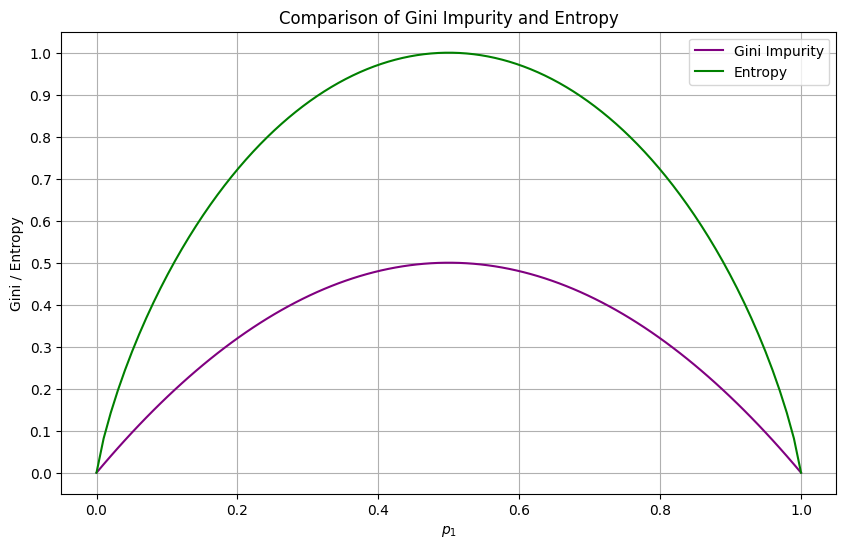

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of probabilities for class 1
p1 = np.linspace(0, 1, 100)
p2 = 1 - p1

# Calculate Gini impurity and entropy for each probability
gini = 1 - (p1 ** 2 + p2 ** 2)
entropy = - (p1 * np.log2(p1 + 1e-10) + p2 * np.log2(p2 + 1e-10))  # Small epsilon to avoid log(0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(p1, gini, label="Gini Impurity", linestyle='-', color='purple')
plt.plot(p1, entropy, label="Entropy", linestyle='-', color='green')
plt.xlabel("$p_1$")
plt.ylabel("Gini / Entropy")
plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-axis to show every 0.1 increment
plt.title("Comparison of Gini Impurity and Entropy")
plt.legend()
plt.grid()
plt.show()

### part c

In [173]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the yeast dataset from OpenML
yeast_data = fetch_openml(name="yeast", version=1)
X = pd.DataFrame(yeast_data.data, columns=yeast_data.feature_names)
y = yeast_data.target

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/list/data_name/yeast/limit/2/data_version/1. Retrying...
  warn(
c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [178]:
X_train.columns

Index(['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc'], dtype='object')

In [177]:
y.unique()

['MIT', 'NUC', 'CYT', 'ME1', 'EXC', 'ME2', 'ME3', 'VAC', 'POX', 'ERL']
Categories (10, object): ['CYT', 'ERL', 'EXC', 'ME1', ..., 'MIT', 'NUC', 'POX', 'VAC']

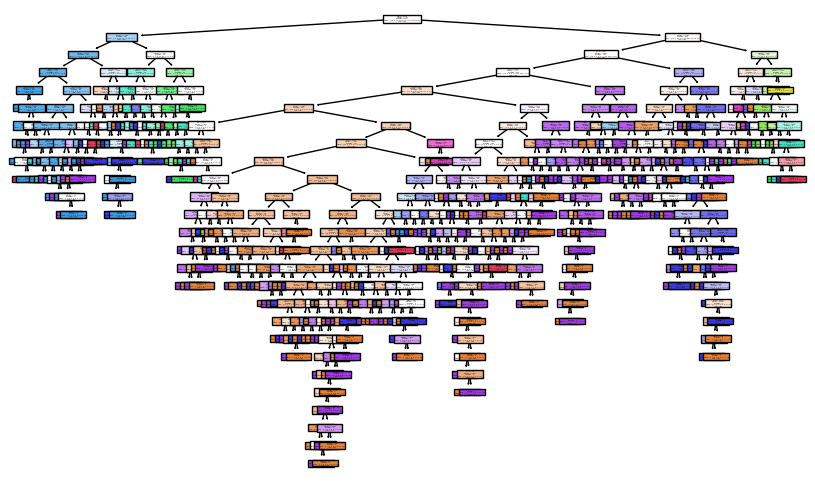

ID3 (Information Gain) Accuracy: 0.4910


In [179]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

classes = ['MIT', 'NUC', 'CYT', 'ME1', 'EXC', 'ME2', 'ME3', 'VAC', 'POX', 'ERL']

# ID3 (Information Gain)
id3_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
id3_tree.fit(X_train, y_train)
id3_predictions = id3_tree.predict(X_test)

# Plot the tree
plt.figure(figsize=(10, 6))
plot_tree(id3_tree, feature_names=X_train.columns, class_names=classes, filled=True)
plt.show()

# Evaluate
id3_accuracy = accuracy_score(y_test, id3_predictions)
print(f"ID3 (Information Gain) Accuracy: {id3_accuracy:.4f}")

In [180]:
# CART (Gini Coefficient)
cart_tree = DecisionTreeClassifier(criterion='gini', random_state=42)
cart_tree.fit(X_train, y_train)
cart_predictions = cart_tree.predict(X_test)

# Evaluate
cart_accuracy = accuracy_score(y_test, cart_predictions)
print(f"CART (Gini Coefficient) Accuracy: {cart_accuracy:.4f}")

CART (Gini Coefficient) Accuracy: 0.5179


In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the yeast dataset from OpenML
yeast_data = fetch_openml(name="yeast", version=1)
X = pd.DataFrame(yeast_data.data, columns=yeast_data.feature_names)
y = yeast_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Custom Tsallis Entropy Decision Tree
class TsallisEntropyDecisionTree:
    def __init__(self, max_depth=None, q=1.0):
        self.max_depth = max_depth
        self.q = q
        self.tree = None
    
    def tsallis_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        q = self.q
        return (1 - np.sum(probabilities ** q)) / (q - 1)
    
    def best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_t_entropy = float('inf')
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = X[:, feature] > threshold
                
                left_entropy = self.tsallis_entropy(y[left_mask])
                right_entropy = self.tsallis_entropy(y[right_mask])
                
                t_entropy = (len(y[left_mask]) / len(y)) * left_entropy + (len(y[right_mask]) / len(y)) * right_entropy
                
                if t_entropy < best_t_entropy:
                    best_feature = feature
                    best_threshold = threshold
                    best_t_entropy = t_entropy
        
        return best_feature, best_threshold

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return np.unique(y)[0]
        
        feature, threshold = self.best_split(X, y)
        if feature is None:
            return np.unique(y)[0]

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}

    def predict_single(self, x, tree):
        if isinstance(tree, dict):
            feature = tree['feature']
            threshold = tree['threshold']
            if x[feature] <= threshold:
                return self.predict_single(x, tree['left'])
            else:
                return self.predict_single(x, tree['right'])
        else:
            return tree

    def predict(self, X):
        return np.array([self.predict_single(x, self.tree) for x in X])

c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [214]:
# Try different values of q and store accuracies for plotting
q_values = np.linspace(0.3, 8, 20)
accuracies = []

for q in q_values:
    tsallis_tree = TsallisEntropyDecisionTree(max_depth=10, q=q)
    tsallis_tree.fit(X_train.values, y_train.values)
    tsallis_predictions = tsallis_tree.predict(X_test.values)
    
    accuracy = accuracy_score(y_test, tsallis_predictions)
    accuracies.append(accuracy)

    print(f'Tsallis entropy with q = {q} achieved accuracy of: {accuracy}')

Tsallis entropy with q = 0.3 achieved accuracy of: 0.515695067264574
Tsallis entropy with q = 0.7052631578947368 achieved accuracy of: 0.5291479820627802
Tsallis entropy with q = 1.1105263157894736 achieved accuracy of: 0.5179372197309418
Tsallis entropy with q = 1.5157894736842106 achieved accuracy of: 0.46860986547085204
Tsallis entropy with q = 1.9210526315789473 achieved accuracy of: 0.5224215246636771
Tsallis entropy with q = 2.326315789473684 achieved accuracy of: 0.5201793721973094
Tsallis entropy with q = 2.731578947368421 achieved accuracy of: 0.5179372197309418
Tsallis entropy with q = 3.1368421052631574 achieved accuracy of: 0.47085201793721976
Tsallis entropy with q = 3.5421052631578944 achieved accuracy of: 0.45964125560538116
Tsallis entropy with q = 3.9473684210526314 achieved accuracy of: 0.46860986547085204
Tsallis entropy with q = 4.352631578947368 achieved accuracy of: 0.4910313901345291
Tsallis entropy with q = 4.757894736842105 achieved accuracy of: 0.4887892376681

In [215]:
best_accuracy = max(accuracies)
best_q = q_values[accuracies.index(best_accuracy)]

print(f'Best accuracy at q = {best_q:.3f}: {best_accuracy:.4f}')

Best accuracy at q = 0.705: 0.5291


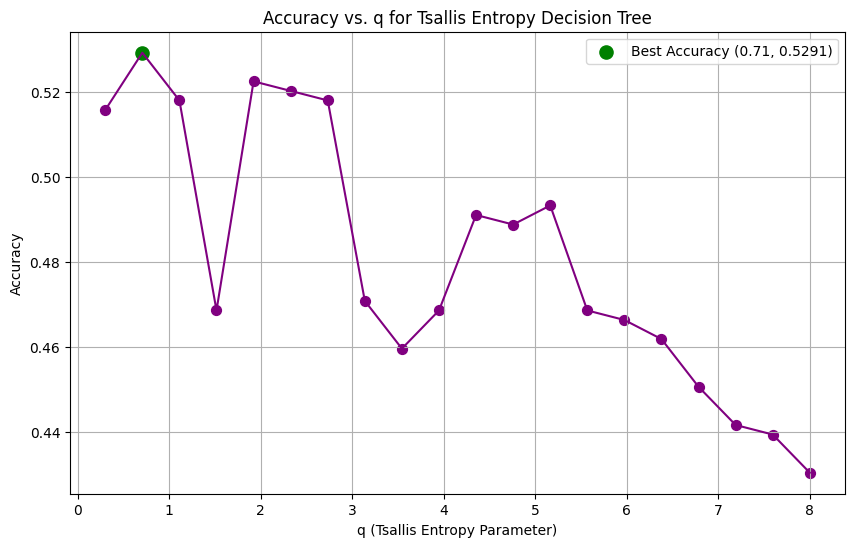

In [212]:
# Plot accuracy as a function of q
plt.figure(figsize=(10, 6))
plt.plot(q_values, accuracies, color='purple')

for i, q in enumerate(q_values):
    plt.scatter(q, accuracies[i],
                s = 90 if accuracies[i] == best_accuracy else 50,
                color='green' if accuracies[i] == best_accuracy else 'purple', 
                label=f"Best Accuracy ({best_q:.2f}, {best_accuracy:.4f})" if accuracies[i] == best_accuracy else '')

plt.xlabel("q (Tsallis Entropy Parameter)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. q for Tsallis Entropy Decision Tree")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Define parameters
q_values = np.linspace(0.3, 8, 20)
num_runs = 10
all_accuracies = {q: [] for q in q_values}  # Dictionary to store accuracies for each q

# Run experiment multiple times
for run in range(num_runs):
    # Split the data randomly each time
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)

    for q in q_values:
        tsallis_tree = TsallisEntropyDecisionTree(max_depth=10, q=q)
        tsallis_tree.fit(X_train.values, y_train.values)
        tsallis_predictions = tsallis_tree.predict(X_test.values)
        
        accuracy = accuracy_score(y_test, tsallis_predictions)
        all_accuracies[q].append(accuracy)

# Calculate average accuracy for each q
average_accuracies = [np.mean(all_accuracies[q]) for q in q_values]

# Find the best average accuracy and corresponding q value
best_average_accuracy = max(average_accuracies)
best_q = q_values[average_accuracies.index(best_average_accuracy)]

# Plot average accuracy as a function of q, highlighting the best point
# plt.figure(figsize=(10, 6))
# plt.plot(q_values, average_accuracies, marker='o', label="Average Accuracy")
# plt.scatter(best_q, best_average_accuracy, color='red', label=f"Best Average Accuracy ({best_q:.2f}, {best_average_accuracy:.4f})")
# plt.xlabel("q (Tsallis Entropy Parameter)")
# plt.ylabel("Average Accuracy")
# plt.title("Average Accuracy vs. q for Tsallis Entropy Decision Tree")
# plt.legend()
# plt.grid()
# plt.show()

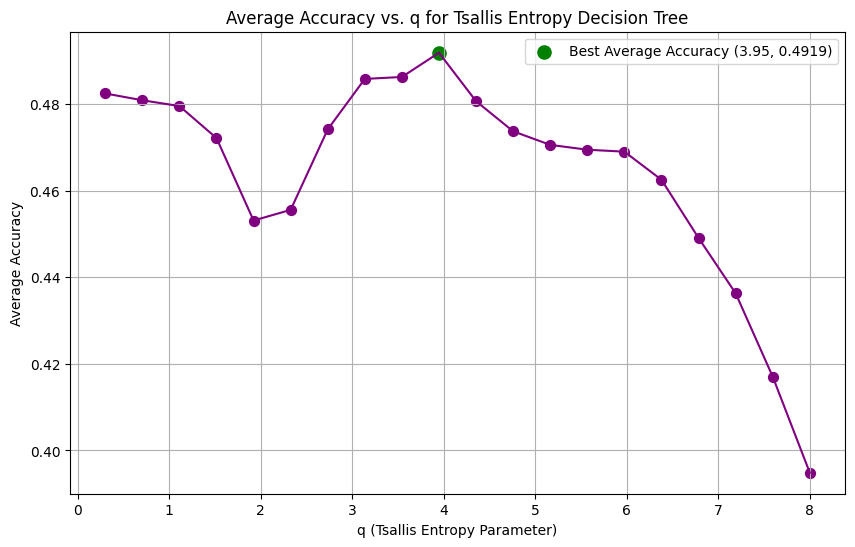

In [217]:
# Plot accuracy as a function of q
plt.figure(figsize=(10, 6))
plt.plot(q_values, average_accuracies, color='purple')
for i, q in enumerate(q_values):
    plt.scatter(q, average_accuracies[i],
                s = 90 if average_accuracies[i] == best_average_accuracy else 50,
                color='green' if average_accuracies[i] == best_average_accuracy else 'purple', 
                label=f"Best Average Accuracy ({best_q:.2f}, {best_average_accuracy:.4f})" if average_accuracies[i] == best_average_accuracy else '')
plt.xlabel("q (Tsallis Entropy Parameter)")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy vs. q for Tsallis Entropy Decision Tree")
plt.grid()
plt.legend()
plt.show()

In [218]:
# Datasets to use
dataset_names = ["yeast", "glass", "vehicle", "wine", "haberman", "car", "scale", "hayes-roth", "monks-problems-1", "abalone"]
q_values = np.linspace(0.3, 8, 20)
num_runs = 10

# Dictionary to store results for each dataset
results = {}

for dataset_name in dataset_names:
    print(f'Importing {dataset_name}...')
    # Fetch the dataset from OpenML
    data = fetch_openml(name=dataset_name, version=1)
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target

    # Dictionary to store accuracies for each q value across all runs
    all_accuracies = {q: [] for q in q_values}
    
    # Run the experiment multiple times for random splits
    for run in range(num_runs):
        print(f'{dataset_name} run #{run}...')

        # Split the data randomly each time
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=run)

        # Iterate through q values and calculate accuracies
        for q in q_values:
            tsallis_tree = TsallisEntropyDecisionTree(max_depth=10, q=q)
            tsallis_tree.fit(X_train.values, y_train.values)
            tsallis_predictions = tsallis_tree.predict(X_test.values)
            
            accuracy = accuracy_score(y_test, tsallis_predictions)
            all_accuracies[q].append(accuracy)
    
    # Calculate average accuracy for each q and store the results
    average_accuracies = {q: np.mean(all_accuracies[q]) for q in q_values}
    best_q = max(average_accuracies, key=average_accuracies.get)
    best_accuracy = average_accuracies[best_q]
    
    # Store results for this dataset
    results[dataset_name] = {
        "average_accuracies": average_accuracies,
        "best_q": best_q,
        "best_accuracy": best_accuracy
    }
    print(results[dataset_name])

Importing yeast...
yeast run #0...


c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


yeast run #1...
yeast run #2...
yeast run #3...
yeast run #4...
yeast run #5...
yeast run #6...
yeast run #7...
yeast run #8...
yeast run #9...
{'average_accuracies': {0.3: 0.4825112107623319, 0.7052631578947368: 0.48094170403587444, 1.1105263157894736: 0.47959641255605384, 1.5157894736842106: 0.4721973094170403, 1.9210526315789473: 0.4531390134529148, 2.326315789473684: 0.45560538116591925, 2.731578947368421: 0.47421524663677134, 3.1368421052631574: 0.4858744394618834, 3.5421052631578944: 0.4863228699551569, 3.9473684210526314: 0.49192825112107624, 4.352631578947368: 0.48071748878923765, 4.757894736842105: 0.47376681614349775, 5.163157894736842: 0.47062780269058296, 5.568421052631579: 0.4695067264573991, 5.973684210526315: 0.4690582959641256, 6.378947368421052: 0.4625560538116592, 6.784210526315789: 0.4491031390134529, 7.189473684210526: 0.4363228699551569, 7.594736842105263: 0.4170403587443946, 8.0: 0.39484304932735426}, 'best_q': 3.9473684210526314, 'best_accuracy': 0.49192825112107

c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


glass run #0...
glass run #1...
glass run #2...
glass run #3...
glass run #4...
glass run #5...
glass run #6...
glass run #7...
glass run #8...
glass run #9...
{'average_accuracies': {0.3: 0.6799999999999999, 0.7052631578947368: 0.68, 1.1105263157894736: 0.676923076923077, 1.5157894736842106: 0.7076923076923077, 1.9210526315789473: 0.6599999999999999, 2.326315789473684: 0.6461538461538462, 2.731578947368421: 0.6615384615384615, 3.1368421052631574: 0.643076923076923, 3.5421052631578944: 0.6492307692307692, 3.9473684210526314: 0.6646153846153846, 4.352631578947368: 0.6569230769230769, 4.757894736842105: 0.6415384615384616, 5.163157894736842: 0.62, 5.568421052631579: 0.6415384615384616, 5.973684210526315: 0.643076923076923, 6.378947368421052: 0.643076923076923, 6.784210526315789: 0.6246153846153847, 7.189473684210526: 0.6153846153846154, 7.594736842105263: 0.6076923076923076, 8.0: 0.6076923076923076}, 'best_q': 1.5157894736842106, 'best_accuracy': 0.7076923076923077}
Importing vehicle...


c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


vehicle run #0...
vehicle run #1...
vehicle run #2...
vehicle run #3...
vehicle run #4...
vehicle run #5...
vehicle run #6...
vehicle run #7...
vehicle run #8...
vehicle run #9...
{'average_accuracies': {0.3: 0.681496062992126, 0.7052631578947368: 0.725984251968504, 1.1105263157894736: 0.7240157480314962, 1.5157894736842106: 0.6980314960629921, 1.9210526315789473: 0.6814960629921261, 2.326315789473684: 0.6700787401574803, 2.731578947368421: 0.6496062992125984, 3.1368421052631574: 0.6775590551181102, 3.5421052631578944: 0.6574803149606299, 3.9473684210526314: 0.666535433070866, 4.352631578947368: 0.6129921259842519, 4.757894736842105: 0.5751968503937007, 5.163157894736842: 0.5669291338582676, 5.568421052631579: 0.5173228346456693, 5.973684210526315: 0.5019685039370079, 6.378947368421052: 0.4440944881889764, 6.784210526315789: 0.42047244094488184, 7.189473684210526: 0.4023622047244094, 7.594736842105263: 0.38700787401574804, 8.0: 0.37637795275590546}, 'best_q': 0.7052631578947368, 'best_

c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


wine run #0...
wine run #1...
wine run #2...
wine run #3...
wine run #4...
wine run #5...
wine run #6...
wine run #7...
wine run #8...
wine run #9...
{'average_accuracies': {0.3: 0.9481481481481481, 0.7052631578947368: 0.9407407407407409, 1.1105263157894736: 0.9203703703703704, 1.5157894736842106: 0.912962962962963, 1.9210526315789473: 0.9166666666666667, 2.326315789473684: 0.9185185185185185, 2.731578947368421: 0.9185185185185185, 3.1368421052631574: 0.9148148148148149, 3.5421052631578944: 0.9259259259259259, 3.9473684210526314: 0.9222222222222222, 4.352631578947368: 0.9333333333333332, 4.757894736842105: 0.9351851851851851, 5.163157894736842: 0.9425925925925925, 5.568421052631579: 0.9425925925925925, 5.973684210526315: 0.9425925925925925, 6.378947368421052: 0.9425925925925925, 6.784210526315789: 0.9555555555555555, 7.189473684210526: 0.9537037037037036, 7.594736842105263: 0.9425925925925925, 8.0: 0.937037037037037}, 'best_q': 6.784210526315789, 'best_accuracy': 0.9555555555555555}
Im

c:\Users\lujai\anaconda3\envs\mlr570\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


haberman run #0...
haberman run #1...


IndexError: index 0 is out of bounds for axis 0 with size 0

In [219]:
# Results are now stored in the `results` dictionary and can be accessed later
# Print summary of results for each dataset
for dataset_name, result in results.items():
    print(f"Dataset: {dataset_name}")
    print(f"  Best q: {result['best_q']}")
    print(f"  Best Average Accuracy: {result['best_accuracy']:.4f}")

Dataset: yeast
  Best q: 3.9473684210526314
  Best Average Accuracy: 0.4919
Dataset: glass
  Best q: 1.5157894736842106
  Best Average Accuracy: 0.7077
Dataset: vehicle
  Best q: 0.7052631578947368
  Best Average Accuracy: 0.7260
Dataset: wine
  Best q: 6.784210526315789
  Best Average Accuracy: 0.9556
